In [1]:
import numpy as np
from astropy.coordinates import EarthLocation
from  astropy import units

In [2]:
def ecef_to_lla(x_m, y_m, z_m):
    """
    Convert earth-centered, earth-fixed coordinates to (rad), longitude
    (rad), elevation (m) using Bowring's method.
    """
    # WGS84 Defining Parameters
    a = 6378137.0                           # semi-major axis of Earth in m
    f = 1.0 / 298.257223563                 # flattening of Earth

    # WGS84 derived geometric constants
    b = a * (1.0 - f)                       # semi-minor axis in m
    e2 = 2 * f - f ** 2                     # first eccentricity squared
    ep2 = f * (2.0 - f) / (1.0 - f) ** 2    # second eccentricity squared

    # Define squared terms for convenience
    a2, b2 = a ** 2, b ** 2
    x2, y2, z2 = x_m ** 2, y_m ** 2, z_m ** 2

    r = np.sqrt(x2 + y2)
    E2 = a2 - b2
    F = 54.0 * b2 * z2
    G = r ** 2 + (1 - e2) * z2 - e2 * E2
    C = (e2 ** 2 * F * r ** 2) / (G ** 3)
    S = (1.0 + C + np.sqrt(C ** 2 + 2 * C)) ** (1. / 3.)
    P = F / (3.0 * (S + 1.0 / S + 1.0) ** 2 * G ** 2)
    Q = np.sqrt(1.0 + 2.0 * e2 ** 2 * P)
    r0 = - P * e2 * r / (1.0 + Q) + \
        np.sqrt(0.5 * a2 * (1.0 + 1.0 / Q) - P * (1 - e2) * z2 / (Q * (1.0 + Q)) - 0.5 * P * r ** 2)
    U = np.sqrt((r - e2 * r0) ** 2 + z2)
    V = np.sqrt((r - e2 * r0) ** 2 + (1.0 - e2) * z2)
    z0 = (b2 * z_m) / (a * V)
    alt_m = U * (1.0 - b2 / (a * V))
    lat_rad = np.arctan2(z_m + ep2 * z0, r)
    long_rad = np.arctan2(y_m, x_m)

    return lat_rad, long_rad, alt_m


def lla_to_ecef(lat_rad, long_rad, alt_m):
    """Convert WGS84 spherical coordinates to ECEF cartesian coordinates.
    :param lat:
    :param lon:
    :param alt:
    :result ecef:
    """
    # WGS84 Defining Parameters
    a = 6378137.0                           # semi-major axis of Earth in m
    f = 1.0 / 298.257223563                 # flattening of Earth

    # WGS84 derived geometric constants
    e2 = 2 * f - f ** 2                     # first eccentricity squared

    # intermediate calculation
    # (normal, or prime vertical radius of curvature)
    R = a / np.sqrt(1.0 - e2 * np.sin(lat_rad) ** 2)

    x_m = (R + alt_m) * np.cos(lat_rad) * np.cos(long_rad)
    y_m = (R + alt_m) * np.cos(lat_rad) * np.sin(long_rad)
    z_m = ((1.0 - e2) * R + alt_m) * np.sin(lat_rad)

    return x_m, y_m, z_m


def ecef_to_enu(location, xyz):
    """Convert ECEF coordinates to ENU coordinates relative to reference location.
    :param location: Current WGS84 coordinate
    :param xyz: ECEF coordinate
    :result : enu
    """
    # ECEF coordinates of reference point
    lon = location.geodetic[0].to(units.rad).value
    lat = location.geodetic[1].to(units.rad).value
    alt = location.geodetic[2].to(units.m).value
    x, y, z = np.hsplit(xyz, 3)  # pylint: disable=unbalanced-tuple-unpacking

    center_x, center_y, center_z = lla_to_ecef(lat, lon, alt)

    delta_x, delta_y, delta_z = x - center_x, y - center_y, z - center_z
    sin_lat, cos_lat = np.sin(lat), np.cos(lat)
    sin_lon, cos_lon = np.sin(lon), np.cos(lon)

    e = -sin_lon * delta_x + cos_lon * delta_y
    n = -sin_lat * cos_lon * delta_x - sin_lat * sin_lon * delta_y + cos_lat * delta_z
    u = cos_lat * cos_lon * delta_x + cos_lat * sin_lon * delta_y + sin_lat * delta_z

    return np.hstack([e, n, u])

def ecef_to_enu2(lon,lat,alt, x,y,z):
    """Convert ECEF coordinates to ENU coordinates relative to reference location.
    :param location: Current WGS84 coordinate
    :param xyz: ECEF coordinate
    :result : enu
    """
    center_x, center_y, center_z = lla_to_ecef(lat, lon, alt)

    delta_x, delta_y, delta_z = x - center_x, y - center_y, z - center_z
    sin_lat, cos_lat = np.sin(lat), np.cos(lat)
    sin_lon, cos_lon = np.sin(lon), np.cos(lon)

    e = -sin_lon * delta_x + cos_lon * delta_y
    n = -sin_lat * cos_lon * delta_x - sin_lat * sin_lon * delta_y + cos_lat * delta_z
    u = cos_lat * cos_lon * delta_x + cos_lat * sin_lon * delta_y + sin_lat * delta_z

    return np.hstack([e, n, u])

def xyz_at_latitude(local_xyz, lat):
    """
    Rotate local XYZ coordinates into celestial XYZ coordinates. These
    coordinate systems are very similar, with X pointing towards the
    geographical east in both cases. However, before the rotation Z
    points towards the zenith, whereas afterwards it will point towards
    celestial north (parallel to the earth axis).

    :param lat: target latitude (radians or astropy quantity)
    :param local_xyz: Array of local XYZ coordinates
    :return: Celestial XYZ coordinates
    """

    # return enu_to_eci(local_xyz, lat)
    x, y, z = np.hsplit(local_xyz, 3)  # pylint: disable=unbalanced-tuple-unpacking

    lat2 = np.pi / 2 - lat
    y2 = -z * np.sin(lat2) + y * np.cos(lat2)
    z2 = z * np.cos(lat2) + y * np.sin(lat2)

    return np.hstack([x, y2, z2])
def xyz_to_uvw(xyz, ha, dec):
    """
    Rotate :math:`(x,y,z)` positions in earth coordinates to
    :math:`(u,v,w)` coordinates relative to astronomical source
    position :math:`(ha, dec)`. Can be used for both antenna positions
    as well as for baselines.

    Hour angle and declination can be given as single values or arrays
    of the same length. Angles can be given as radians or astropy
    quantities with a valid conversion.

    :param xyz: :math:`(x,y,z)` co-ordinates of antennas in array
    :param ha: hour angle of phase tracking centre (:math:`ha = ra - lst`)
    :param dec: declination of phase tracking centre.
    """

    # return eci_to_uvw(xyz, ha, dec)
    x, y, z = np.hsplit(xyz, 3)  # pylint: disable=unbalanced-tuple-unpacking

    # Two rotations:
    #  1. by 'ha' along the z axis
    #  2. by '90-dec' along the u axis
    u = x * np.cos(ha) - y * np.sin(ha)
    v0 = x * np.sin(ha) + y * np.cos(ha)
    w = z * np.sin(dec) - v0 * np.cos(dec)
    v = z * np.cos(dec) + v0 * np.sin(dec)

    return np.hstack([u, v, w])

In [3]:
def azel_to_enu(az_rad, el_rad):
    sin_az, cos_az = np.sin(az_rad), np.cos(az_rad)
    sin_el, cos_el = np.sin(el_rad), np.cos(el_rad)
    return sin_az * cos_el, cos_az * cos_el, sin_el

In [4]:
def kapoint_rotation(az,el,offset_az,offset_el,offset_sign):
    w = np.array(azel_to_enu(az, el))
    # enu vector pointing from reference antenna to offset point
    z = np.array(azel_to_enu(offset_az, offset_el))
    # u axis is orthogonal to z and w, and row_stack makes it 2-D array of column vectors
    u = np.row_stack(np.cross(z, w, axis=0)) * offset_sign
    u_norm = np.sqrt(np.sum(u ** 2, axis=0))
    # Ensure that u and w (and therefore v) have the same shape to handle scalar vs array output correctly
    u = u.reshape(w.shape) / u_norm
    v = np.cross(w, u, axis=0)
    return np.array([u, v, w])

In [5]:
def hadec_to_azel(ha, dec, latitude):
    """Convert HA Dec to Az El

    TMS Appendix 4.1

    sinel = sinlat sindec + coslat cosdec cosha
    cosel cosaz = coslat sindec - sinlat cosdec cosha
    cosel sinaz = - cosdec sinha

    :param ha:
    :param dec:
    :param latitude:
    :return: az, el
    """
    coslat = np.cos(latitude)
    sinlat = np.sin(latitude)
    cosdec = np.cos(dec)
    sindec = np.sin(dec)
    cosha = np.cos(ha)
    sinha = np.sin(ha)

    az = np.arctan2(-cosdec * sinha, (coslat * sindec - sinlat * cosdec * cosha))
    el = np.arcsin(sinlat * sindec + coslat * cosdec * cosha)
    return az, el

In [6]:
mid_location = EarthLocation(
        lon=21.443803 * units.deg, lat=-30.712925 * units.deg, height=1053.000000
    )

In [7]:
midcfg="/home/xieyangfan/projects/rascil_main_master/rascil2/data/configurations/ska1mid.cfg"
with open(midcfg,"r") as f:
    mid = f.readlines()

midconfig = []
for line in mid:
    if "#" in line:
        continue
    else:
        midconfig.append(
            list(map(float,line.strip().split()[:3]))
        )

midconfig_XYZ = np.array(midconfig)
midconfig_lla = np.array(
    ecef_to_lla(midconfig_XYZ[:,0],midconfig_XYZ[:,1],midconfig_XYZ[:,2])
).T
midconfig_ENU = ecef_to_enu(mid_location,midconfig_XYZ)

In [43]:
ha,dec=np.deg2rad(30),np.deg2rad(-37)
dec_off = dec + 0.03

In [44]:
# katpoint orgin

lat_list = midconfig_lla[:,0]
lon_list = midconfig_lla[:,1]

lon_list_off = lon_list - mid_location.geodetic[0].to(units.rad).value
ha_list = ha + lon_list_off

az_list,el_list = hadec_to_azel(
    ha_list, # 这里应该每个天线，也都不一样
    dec,
    lat_list)
az_off_list,el_off_list = hadec_to_azel(
    ha_list,
    dec_off,
    lat_list)


katrot = []
for az,el,az_off,el_off in zip(az_list,el_list,az_off_list,el_off_list):
    katrot.append(kapoint_rotation(az,el,az_off,el_off,1))
katrot = np.array(katrot)

baseline_UVW_katpoint = []
for ant1 in range(0, len(midconfig_ENU)):
    rotation_ant1 = katrot[ant1]
    lla_ant1 = midconfig_lla[ant1]
    for ant2 in range(ant1, len(midconfig_ENU)):
        XYZ_ant2 = midconfig_XYZ[ant2]
        ant1_to_ant2_base_ant1_enu = ecef_to_enu2(
            lla_ant1[1],lla_ant1[0],lla_ant1[2],
            *XYZ_ant2
        )
        this_uvw = np.dot(rotation_ant1,ant1_to_ant2_base_ant1_enu)
        baseline_UVW_katpoint.append(this_uvw)
        tmp_uvw = this_uvw.copy()
        tmp_uvw[0] = -tmp_uvw[0]
        tmp_uvw[1] = -tmp_uvw[1]
        baseline_UVW_katpoint.append(tmp_uvw)
baseline_UVW_katpoint = np.array(baseline_UVW_katpoint)


In [45]:
# rascil
xyzatlat = xyz_at_latitude(midconfig_ENU,mid_location.geodetic[1].to(units.rad).value)
UVW_rascil = xyz_to_uvw(xyzatlat,ha,dec)

baseline_UVW_rascil = []
for ant1 in range(0, UVW_rascil.shape[0]):
    for ant2 in range(ant1, UVW_rascil.shape[0]):
        baseline_UVW_rascil.append(UVW_rascil[ant2]-UVW_rascil[ant1])
        baseline_UVW_rascil.append(UVW_rascil[ant1]-UVW_rascil[ant2])
baseline_UVW_rascil = np.array(baseline_UVW_rascil)

In [46]:
#katpoint use ref

az_ref,el_ref = hadec_to_azel(ha,dec,mid_location.geodetic[1].to(units.rad).value)
az_off_ref,el_off_ref = hadec_to_azel(ha,dec_off,mid_location.geodetic[1].to(units.rad).value)
katrot_one = kapoint_rotation(az_ref,el_ref,az_off_ref,el_off_ref,1)

print(katrot_one.shape)
print(midconfig_ENU[:,:,None].shape)

UVW_katpoint = np.transpose(
np.dot(
    katrot_one, 
    midconfig_ENU[:,:,None],
),(1,0,2)
)[:,:,0]

print(UVW_katpoint.shape)

baseline_UVW_katpoint_one = []
for ant1 in range(0, UVW_katpoint.shape[0]):
    for ant2 in range(ant1, UVW_katpoint.shape[0]):
        baseline_UVW_katpoint_one.append(UVW_katpoint[ant2]-UVW_katpoint[ant1])
        baseline_UVW_katpoint_one.append(UVW_katpoint[ant1]-UVW_katpoint[ant2])
baseline_UVW_katpoint_one = np.array(baseline_UVW_katpoint_one)
baseline_UVW_katpoint_one.shape

(3, 3)
(197, 3, 1)
(197, 3)


(39006, 3)

In [47]:
import matplotlib.pyplot as plt

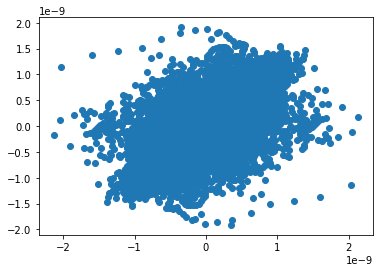

In [48]:
res = baseline_UVW_katpoint - baseline_UVW_rascil
plt.scatter(res[:,0],res[:,1])

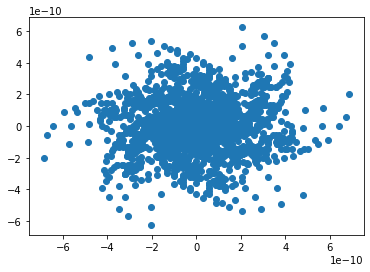

In [49]:
res2 = baseline_UVW_katpoint_one - baseline_UVW_rascil
plt.scatter(res2[:,0],res2[:,1])

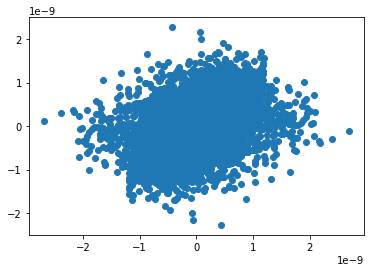

In [50]:
res3 = baseline_UVW_katpoint_one - baseline_UVW_katpoint
plt.scatter(res3[:,0],res3[:,1])

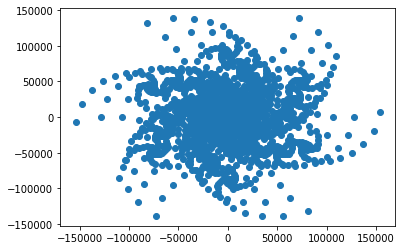

In [16]:
plt.scatter(baseline_UVW_rascil[:,0],baseline_UVW_rascil[:,1])

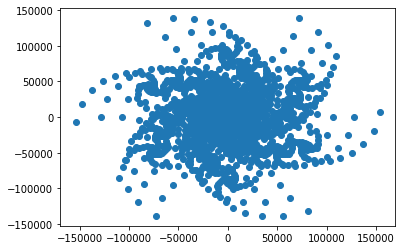

In [17]:
plt.scatter(baseline_UVW_katpoint[:,0],baseline_UVW_katpoint[:,1])

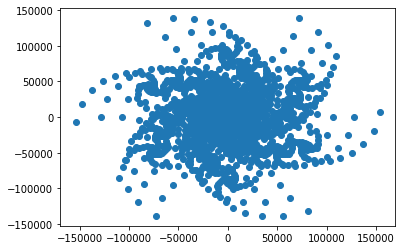

In [18]:
plt.scatter(baseline_UVW_katpoint_one[:,0],baseline_UVW_katpoint_one[:,1])